# 1. Sample 1-10

### 1.0 Load dependencies

In [1]:
import torchvision.datasets as datasets
from numpy import asarray
import pickle
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.utils import shuffle
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import accuracy_score

### 1.1 Create 10 balanced mnist samples using different seeds

In [2]:
import numpy as np
from torchvision import datasets

# Load data
train = datasets.MNIST(root='./data', train=True, download=False, transform=None)
test = datasets.MNIST(root='./data', train=False, download=False, transform=None)

X_train = train.data.numpy()
y_train = train.targets.numpy()
X_test = test.data.numpy()
y_test = test.targets.numpy()

# Function to sample balanced data
def sample_balanced_data(X, y, num_samples_per_class, seed):
    np.random.seed(seed)
    sampled_X = []
    sampled_y = []
    sampled_indices_all = []
    for digit in range(10):
        indices = np.where(y == digit)[0]
        sampled_indices = np.random.choice(indices, num_samples_per_class, replace=False)
        sampled_X.append(X[sampled_indices])
        sampled_y.append(y[sampled_indices])
        sampled_indices_all.extend(sampled_indices)
    return sampled_indices_all, np.concatenate(sampled_X), np.concatenate(sampled_y)

In [3]:
# Repeat the process 10 times with different seeds

num_samples_per_class_trn = 50
num_samples_per_class_tst = 50
num_samples_per_class_hel = 100

for i in range(10):
    seed = i
    _, X_train_sampled, y_train_sampled = sample_balanced_data(X_train, y_train, num_samples_per_class_trn, seed)
    sampled_indices_test, X_test_sampled, y_test_sampled = sample_balanced_data(X_test, y_test, num_samples_per_class_tst, seed)
    
    indices_heldout = [i for i in range(len(X_test)) if i not in sampled_indices_test]
    
    X_heldout_sampled, y_heldout_sampled = [], []
    for digit in range(10):
        indices_heldout_per_class = [i for i in indices_heldout if y_test[i] == digit]
        sampled_indices_heldout = np.random.choice(indices_heldout_per_class, num_samples_per_class_hel, 
                                                   replace=False)
        X_heldout_sampled.append(X_test[sampled_indices_heldout])
        y_heldout_sampled.append(y_test[sampled_indices_heldout])
    
    X_heldout_sampled = np.concatenate(X_heldout_sampled)
    y_heldout_sampled = np.concatenate(y_heldout_sampled)
    
    mydict = {'X_ori':X_train_sampled, 'y_ori':y_train_sampled, 'X_val':X_test_sampled, 'y_val':y_test_sampled,
              'X_heldout':X_heldout_sampled, 'y_heldout':y_heldout_sampled}
    
    with open("data/mnist_balanced_sample/sample{}_num_samples_per_class_trn={}_num_samples_per_class_tst={}".format(i+1, num_samples_per_class_trn, num_samples_per_class_tst) + '.pickle', "wb") as fp:
        pickle.dump(mydict, fp)

In [22]:
np.asarray(range(10))

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [4]:
X_train_sampled.shape

(500, 28, 28)

### 1.2 Perform data augmentation on each mnist sample

In [8]:
def get_aug_params(shift_limit_dx, shift_limit_dy, scale_limit, rotate_limit):
        shift_limit_dx = (-shift_limit_dx, shift_limit_dx)
        shift_limit_dy = (-shift_limit_dy, shift_limit_dy)
        scale_limit = (-scale_limit, scale_limit)
        rotate_limit = (-rotate_limit, rotate_limit)
        return {'angle': random.uniform(rotate_limit[0], rotate_limit[1]),
                'scale': random.uniform(1 + scale_limit[0], 1 + scale_limit[1]),
                'dx': random.uniform(shift_limit_dx[0], shift_limit_dx[1]),
                'dy': random.uniform(shift_limit_dy[0], shift_limit_dy[1])}
    

# This is sourced from the ShiftScaleRotate function in the albumentations library.
# https://github.com/albu/albumentations/blob/c26383ecd9eeb51d57185bfd699179a8a41f7b6d/albumentations/augmentations/functional.py#L143

def shift_scale_rotate(img, angle, scale, dx, dy, 
                       interpolation=cv2.INTER_LINEAR, 
                       border_mode=cv2.BORDER_REFLECT_101):
    
    height, width = img.shape[:2]
    center = (width / 2, height / 2)
    matrix = cv2.getRotationMatrix2D(center, angle, scale)
    matrix[0, 2] += dx * width
    matrix[1, 2] += dy * height
    img = cv2.warpAffine(img, matrix, (width, height), 
                         flags=interpolation, borderMode=border_mode)
    
    return img

def visualize(img, aug_imgs, n_augs):
        f, ax = plt.subplots(1, 1 + n_augs)
        plt.axis('off')
        ax[0].imshow(img, cmap='grey')
        for i in range(n_augs):
            ax[1 + i].imshow(aug_imgs[i], cmap='grey')
        plt.show()

In [6]:
with open("data/mnist_balanced_sample/sample{}_num_samples_per_class_trn={}_num_samples_per_class_tst={}".format(0+1, num_samples_per_class_trn, num_samples_per_class_tst) + '.pickle', "rb") as fp:
    mydict = pickle.load(fp)
    
X_ori = mydict['X_ori']
y_ori = mydict['y_ori']
X_val = mydict['X_val']
y_val = mydict['y_val']

In [7]:
X_ori[i].shape, X_val.shape, X_val.reshape(X_val.shape[0], -1).shape

((28, 28), (500, 28, 28), (500, 784))

In [8]:
y_ori.shape

(500,)

Performing data augmentation for the 1th sample...


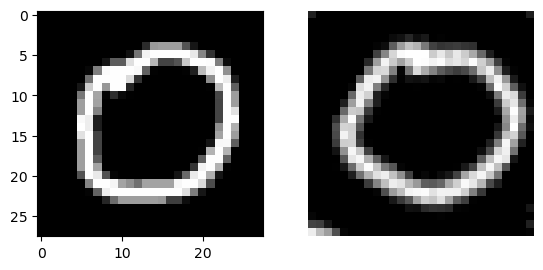

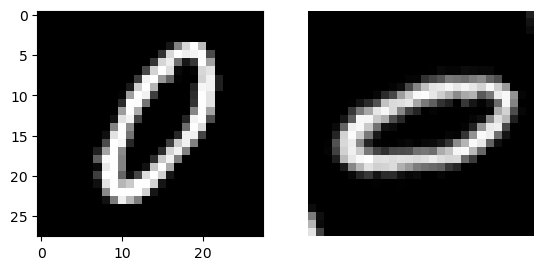

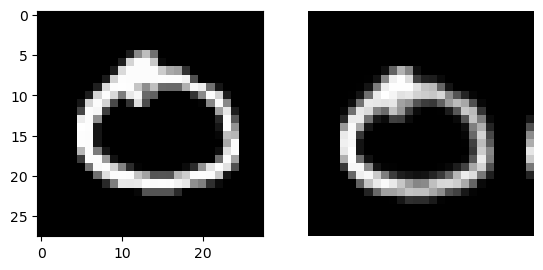

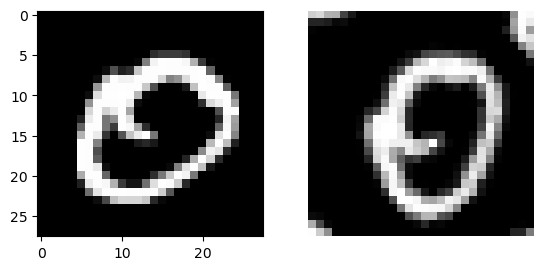

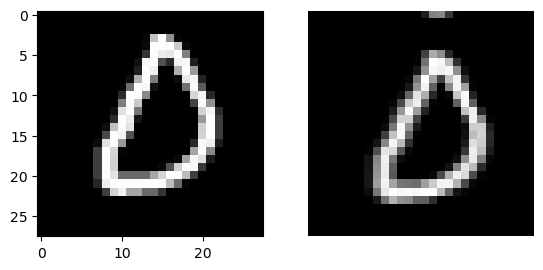

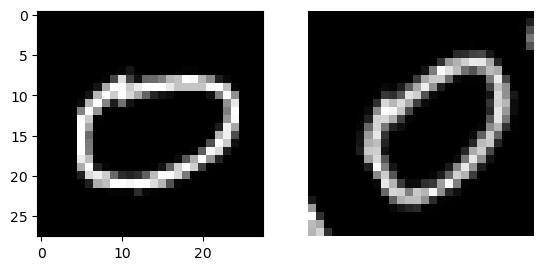

Performing data augmentation for the 2th sample...


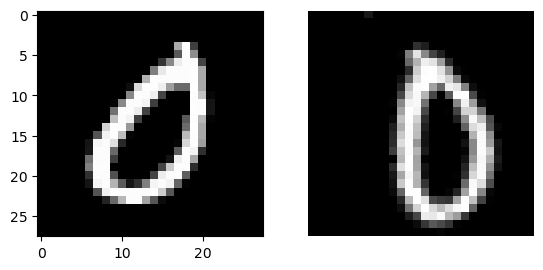

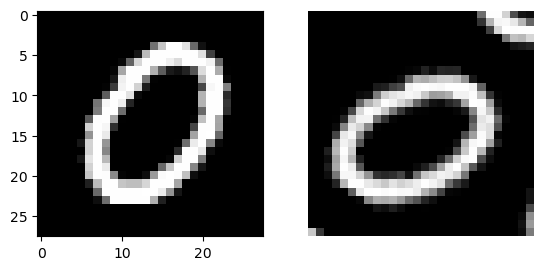

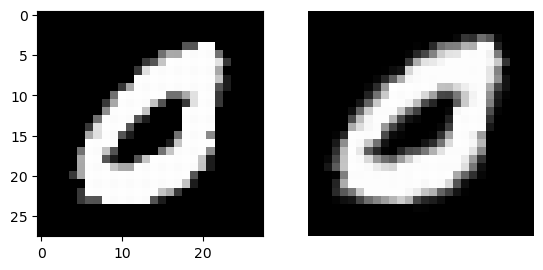

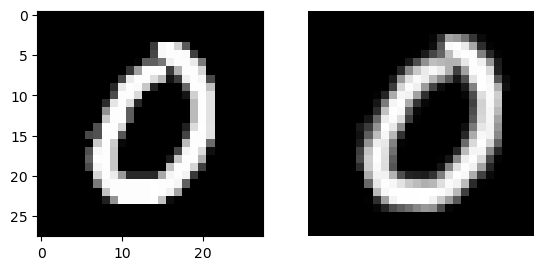

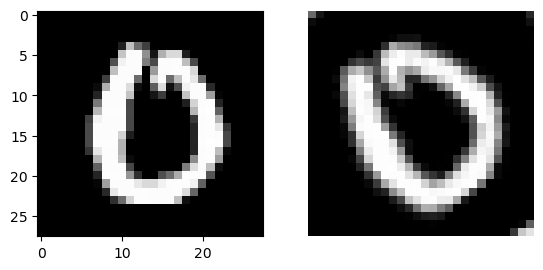

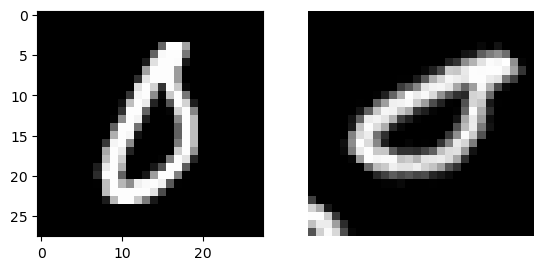

Performing data augmentation for the 3th sample...


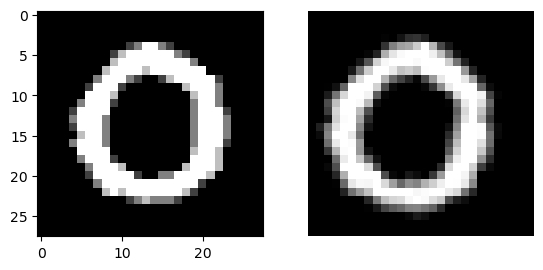

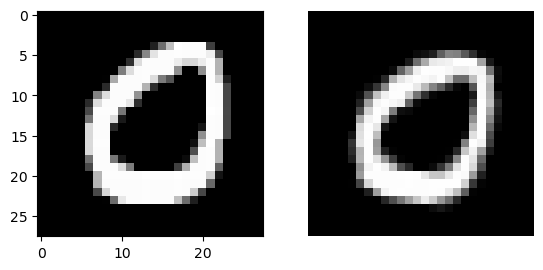

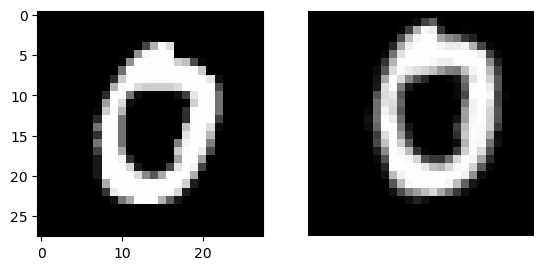

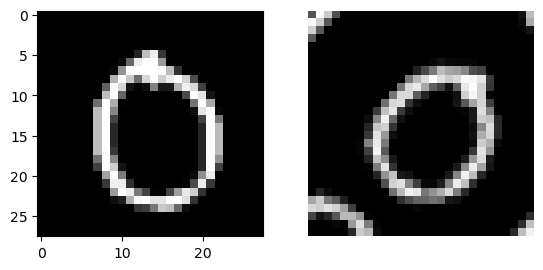

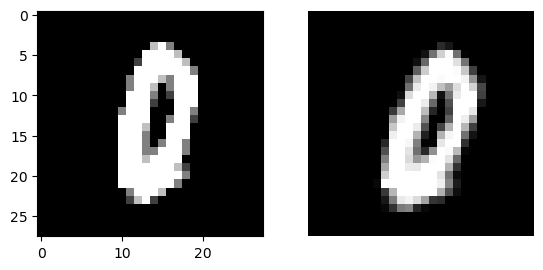

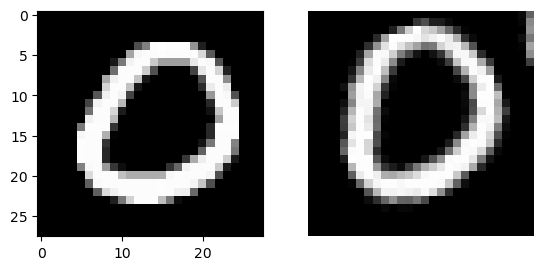

Performing data augmentation for the 4th sample...


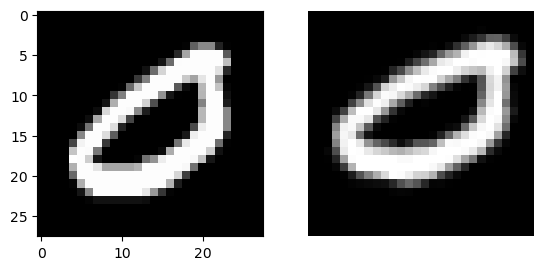

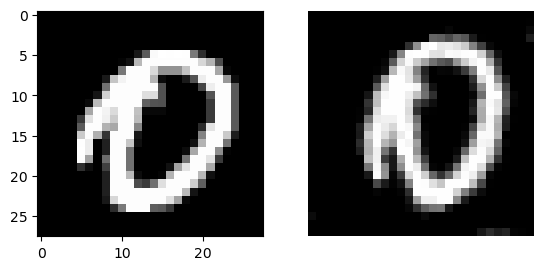

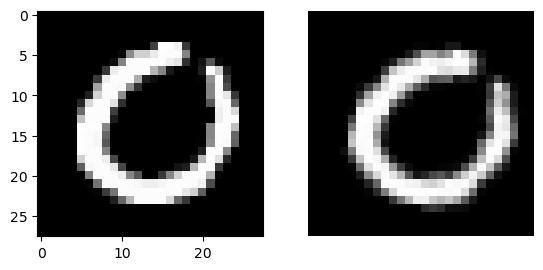

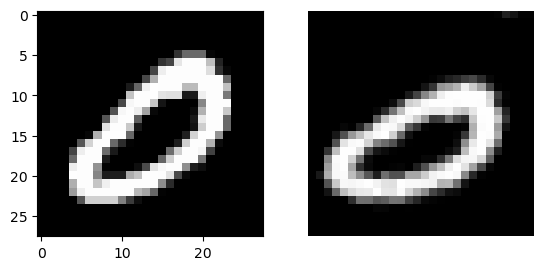

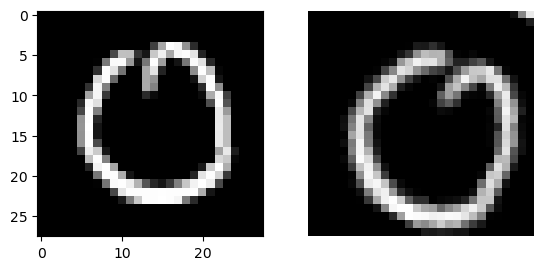

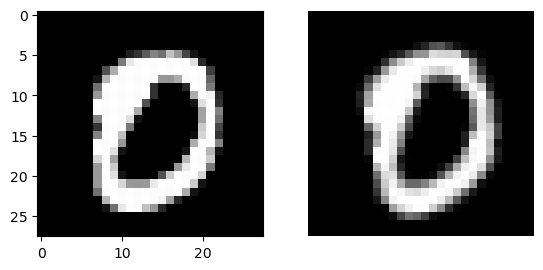

Performing data augmentation for the 5th sample...


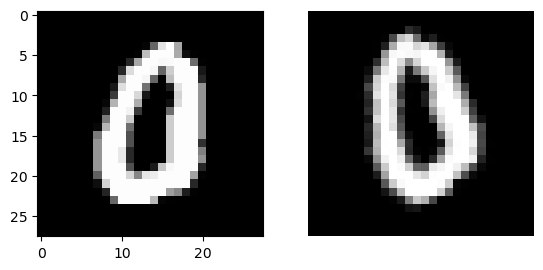

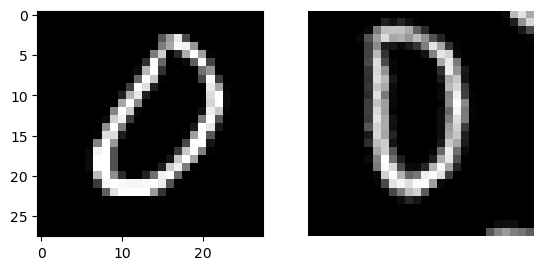

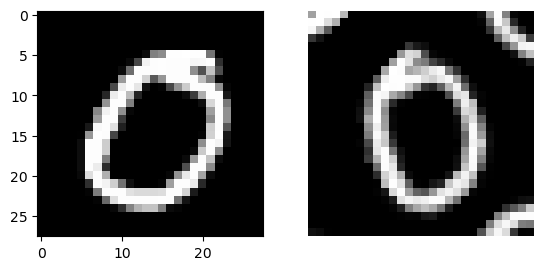

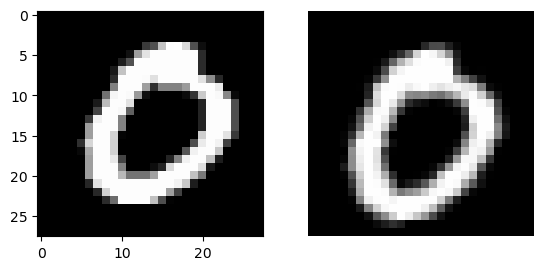

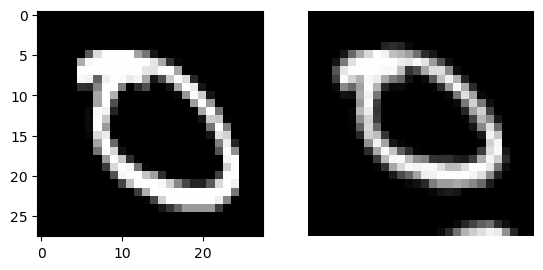

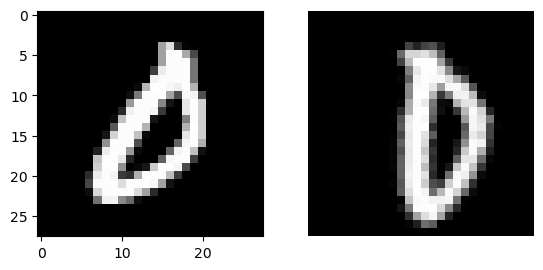

Performing data augmentation for the 6th sample...


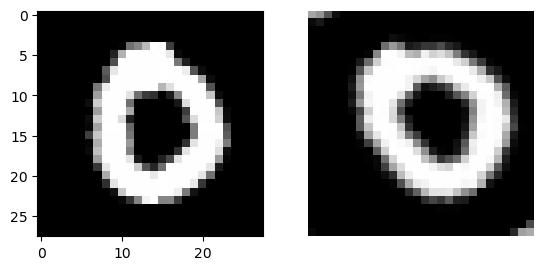

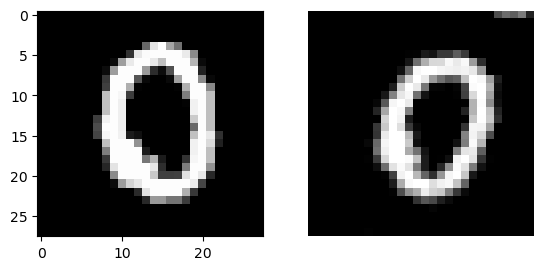

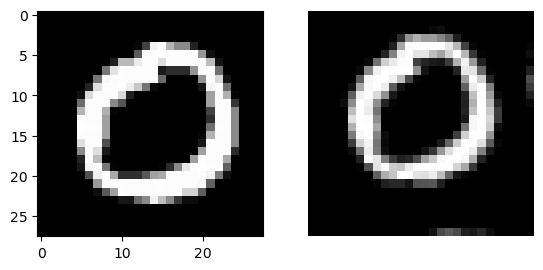

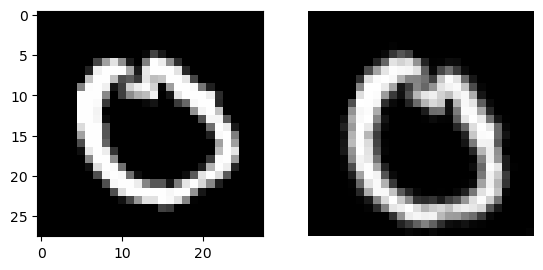

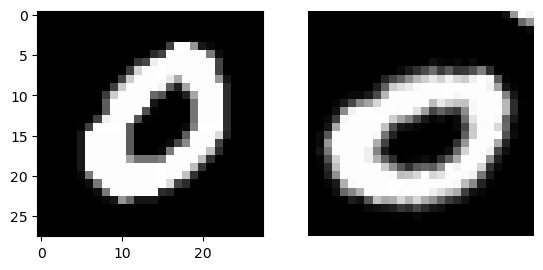

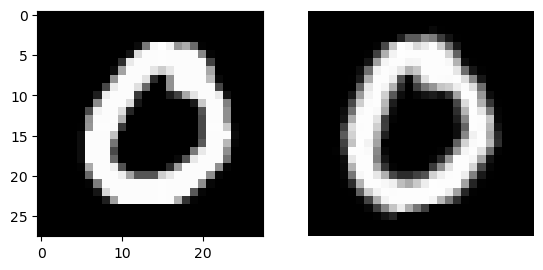

Performing data augmentation for the 7th sample...


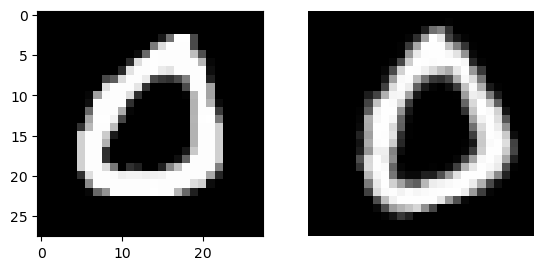

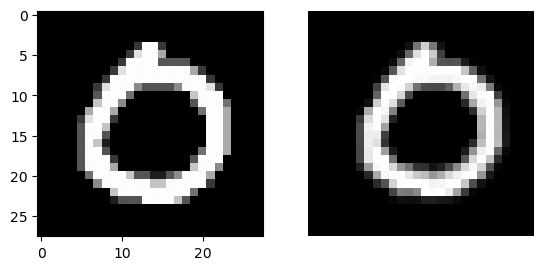

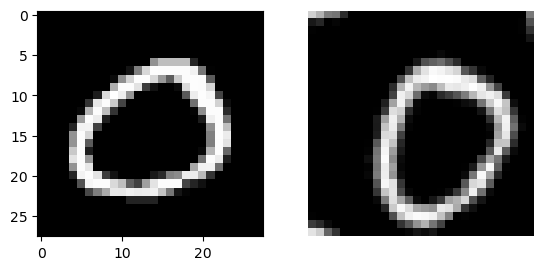

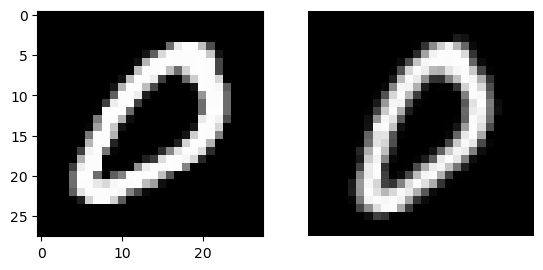

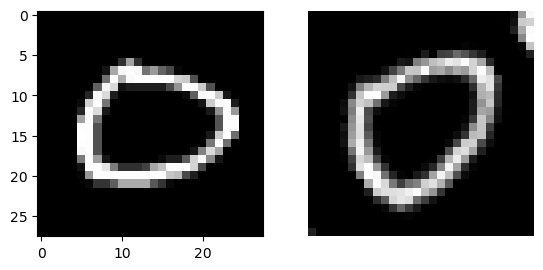

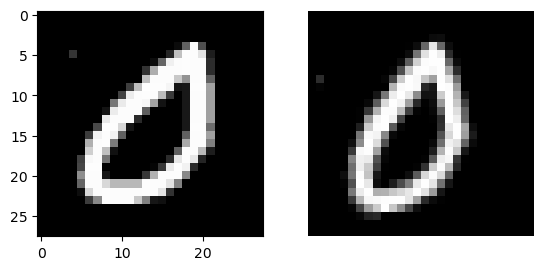

Performing data augmentation for the 8th sample...


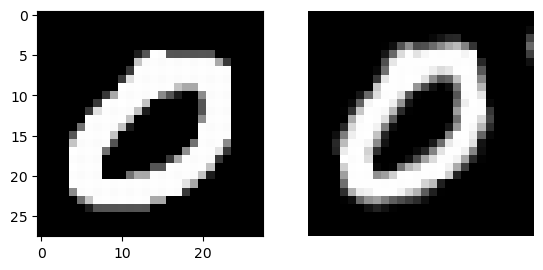

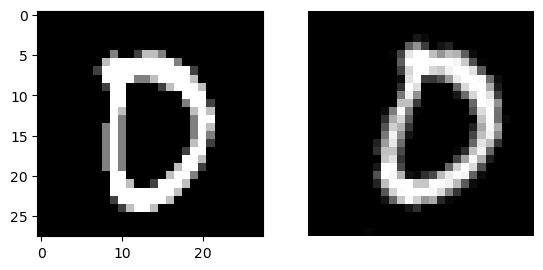

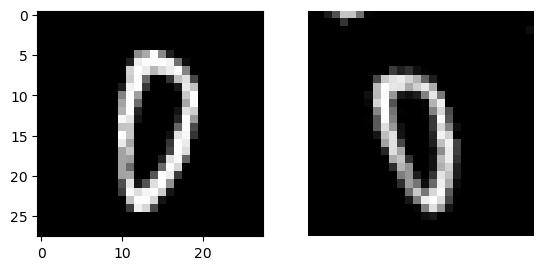

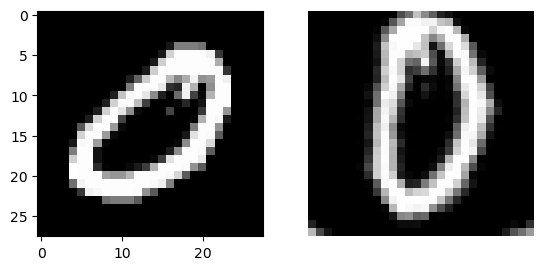

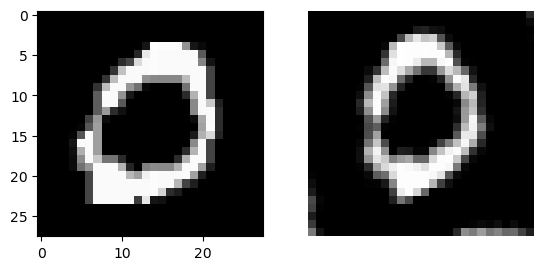

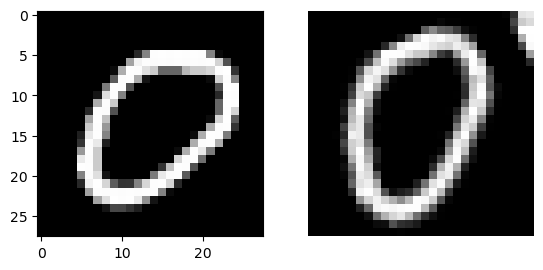

Performing data augmentation for the 9th sample...


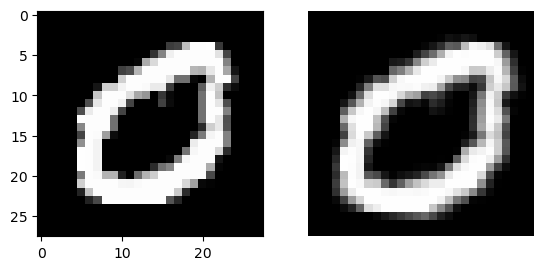

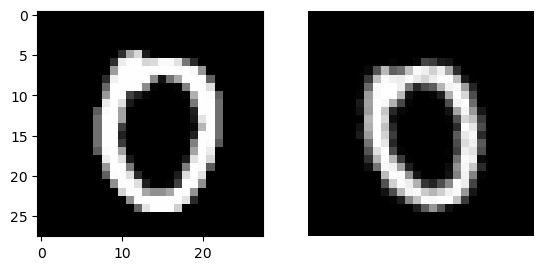

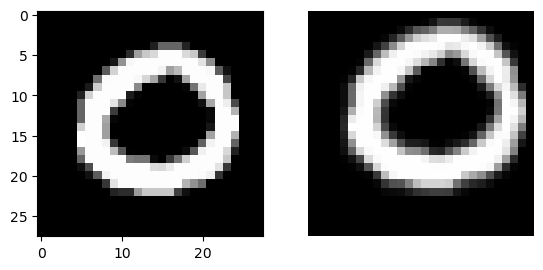

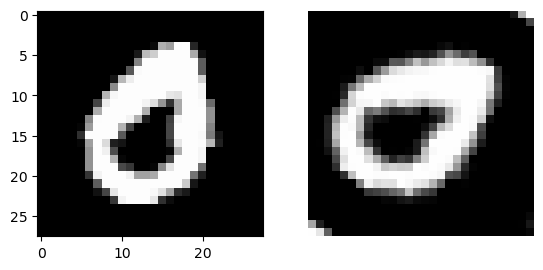

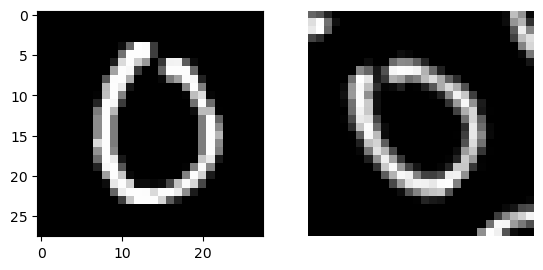

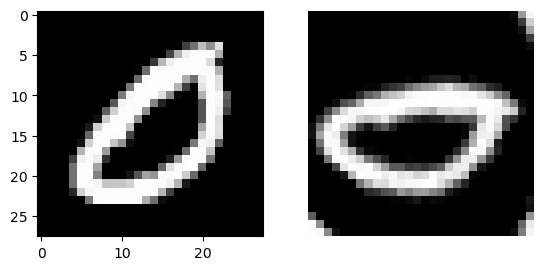

Performing data augmentation for the 10th sample...


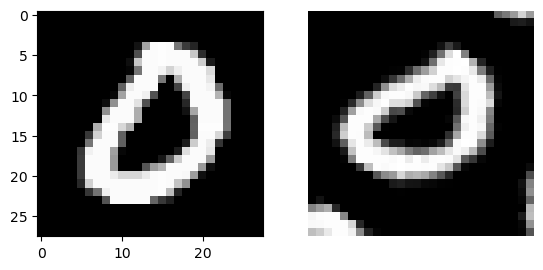

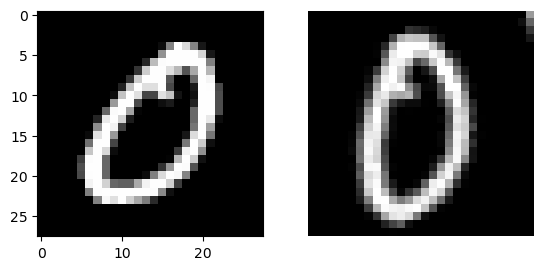

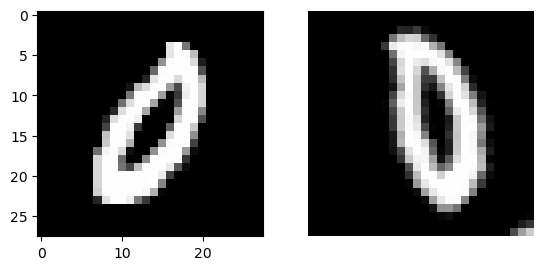

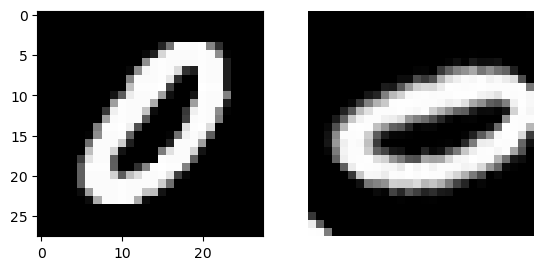

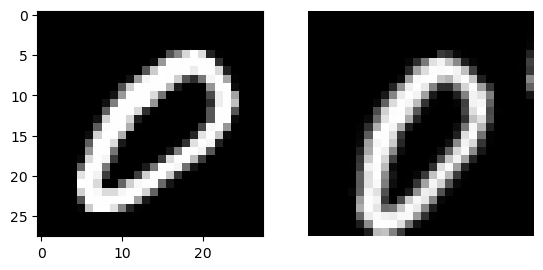

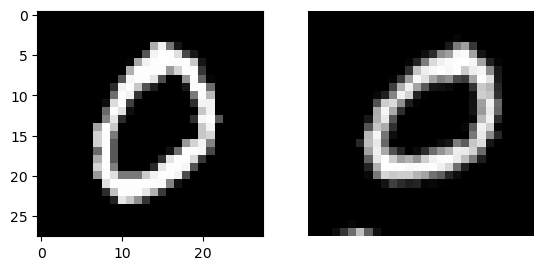

In [9]:
np.random.seed(42)

num_samples_per_class_trn = 50
num_samples_per_class_tst = 50
n_augs, n_vis = 1, 5

shift_limit_dx, shift_limit_dy, scale_limit, rotate_limit = 0.0625, 0.0625, 0.1, 45

for i_sample in range(10):
    
    print('Performing data augmentation for the {}th sample...'.format(i_sample+1))
    
    with open("data/mnist_balanced_sample/sample{}_num_samples_per_class_trn={}_num_samples_per_class_tst={}".format(i_sample+1, num_samples_per_class_trn, num_samples_per_class_tst) + '.pickle', "rb") as fp:
        mydict = pickle.load(fp)
    
    X_ori = mydict['X_ori']
    y_ori = mydict['y_ori']
    X_val = mydict['X_val'].reshape(mydict['X_val'].shape[0], -1)
    y_val = mydict['y_val']
    
    imgs, aug_imgs, y_aug, aug_params = [], [], [], {}
    
    for i, img in enumerate(X_ori):
        img_f = img.flatten()
        imgs.append(img_f)
        aug_img_n = []
        for j in range(n_augs):
            rand_params = get_aug_params(shift_limit_dx, shift_limit_dy, scale_limit, rotate_limit)
            aug_img = shift_scale_rotate(img, rand_params['angle'], rand_params['scale'], rand_params['dx'], rand_params['dy'])
            aug_img_n.append(aug_img)
            aug_params[len(X_ori) + len(aug_imgs)] = rand_params
            aug_imgs.append(aug_img.flatten())
            y_aug.append(y_ori[i])
        if i <= n_vis:
            visualize(img, aug_img_n, n_augs)

    imgs = np.asarray(imgs).astype('int64')
    aug_imgs = np.asarray(aug_imgs).astype('int64')

    X_ori = imgs
    X_aug = aug_imgs
    X_ori_aug = np.concatenate((imgs, aug_imgs))
    y_aug = np.asarray(y_aug)
    y_ori_aug = np.concatenate((y_ori, y_aug))

    mydict = {'X_ori': X_ori, 'y_ori': y_ori, 'X_aug': X_aug, 'y_aug': y_aug, 'X_ori_aug': X_ori_aug,
              'y_ori_aug': y_ori_aug, 'X_val': X_val, 'y_val': y_val, 'aug_params': aug_params}

    with open("data/mnist_balanced_sample/augmented_sample{}_num_samples_per_class_trn={}_num_samples_per_class_tst={}_shift_dx={}_shift_dy={}_scale={}_rotate={}".format(i_sample+1, num_samples_per_class_trn, num_samples_per_class_tst, shift_limit_dx, shift_limit_dy, scale_limit, rotate_limit) + '.pickle', "wb") as fp:
        pickle.dump(mydict, fp)
    

### 3. Compare performance of 5-NN classifiers w and w/o augmentations

In [10]:
K = 5
param_setting = "shift_dx={}_shift_dy={}_scale={}_rotate={}".format(shift_limit_dx, shift_limit_dy, scale_limit, rotate_limit)

for i_sample in range(10):
    print(' ')
    print('Testing the performance of {}th sample...'.format(i_sample+1))
    
    with open("data/mnist_balanced_sample/augmented_sample{}_num_samples_per_class_trn={}_num_samples_per_class_tst={}_".format(i_sample+1, num_samples_per_class_trn, num_samples_per_class_tst) + param_setting + '.pickle', "rb") as fp:
        mydict = pickle.load(fp)
    
    X_ori = mydict['X_ori']
    y_ori = mydict['y_ori']
    X_aug = mydict['X_aug']
    y_aug = mydict['y_aug']
    X_ori_aug = mydict['X_ori_aug']
    y_ori_aug = mydict['y_ori_aug']
    X_val = mydict['X_val']
    y_val = mydict['y_val']
    
    model_ori = KNN(n_neighbors=K, weights='uniform')
    model_ori.fit(X_ori, y_ori)
    preds = model_ori.predict(X_val)
    print('Classification accuracy for original dataset:', accuracy_score(y_val, preds))

    model_aug = KNN(n_neighbors=K, weights='uniform')
    model_aug.fit(X_aug, y_aug)
    preds = model_aug.predict(X_val)
    print('Classification accuracy for augmented dataset:', accuracy_score(y_val, preds))

    model_ori_aug = KNN(n_neighbors=K, weights='uniform')
    model_ori_aug.fit(X_ori_aug, y_ori_aug)
    preds = model_ori_aug.predict(X_val)
    print('Classification accuracy for original and augmented dataset:', accuracy_score(y_val, preds))

 
Testing the performance of 1th sample...
Classification accuracy for original dataset: 0.828
Classification accuracy for augmented dataset: 0.664
Classification accuracy for original and augmented dataset: 0.85
 
Testing the performance of 2th sample...
Classification accuracy for original dataset: 0.864
Classification accuracy for augmented dataset: 0.668
Classification accuracy for original and augmented dataset: 0.836
 
Testing the performance of 3th sample...
Classification accuracy for original dataset: 0.824
Classification accuracy for augmented dataset: 0.686
Classification accuracy for original and augmented dataset: 0.85
 
Testing the performance of 4th sample...
Classification accuracy for original dataset: 0.844
Classification accuracy for augmented dataset: 0.686
Classification accuracy for original and augmented dataset: 0.834
 
Testing the performance of 5th sample...
Classification accuracy for original dataset: 0.818
Classification accuracy for augmented dataset: 0.68

# 2. Sample 11-20

### 2.1 Create 10 balanced mnist samples using different seeds

In [24]:
np.asarray(range(10)), np.asarray(range(10, 20))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19]))

In [25]:
# Repeat the process 10 times with different seeds

num_samples_per_class_trn = 50
num_samples_per_class_tst = 50

for i in range(10, 20):
    seed = i
    X_train_sampled, y_train_sampled = sample_balanced_data(X_train, y_train, num_samples_per_class_trn, seed)
    X_test_sampled, y_test_sampled = sample_balanced_data(X_test, y_test, num_samples_per_class_tst, seed)
    
    mydict = {'X_ori':X_train_sampled, 'y_ori':y_train_sampled, 'X_val':X_test_sampled, 'y_val':y_test_sampled}
    
    with open("data/mnist_balanced_sample/sample{}_num_samples_per_class_trn={}_num_samples_per_class_tst={}".format(i+1, num_samples_per_class_trn, num_samples_per_class_tst) + '.pickle', "wb") as fp:
        pickle.dump(mydict, fp)

### 1.2 Perform data augmentation on each mnist sample

In [27]:
def get_aug_params(shift_limit_dx, shift_limit_dy, scale_limit, rotate_limit, seed):
        np.random.seed(seed)
        shift_limit_dx = (-shift_limit_dx, shift_limit_dx)
        shift_limit_dy = (-shift_limit_dy, shift_limit_dy)
        scale_limit = (-scale_limit, scale_limit)
        rotate_limit = (-rotate_limit, rotate_limit)
        return {'angle': random.uniform(rotate_limit[0], rotate_limit[1]),
                'scale': random.uniform(1 + scale_limit[0], 1 + scale_limit[1]),
                'dx': random.uniform(shift_limit_dx[0], shift_limit_dx[1]),
                'dy': random.uniform(shift_limit_dy[0], shift_limit_dy[1])}
    

# This is sourced from the ShiftScaleRotate function in the albumentations library.
# https://github.com/albu/albumentations/blob/c26383ecd9eeb51d57185bfd699179a8a41f7b6d/albumentations/augmentations/functional.py#L143

def shift_scale_rotate(img, angle, scale, dx, dy, 
                       interpolation=cv2.INTER_LINEAR, 
                       border_mode=cv2.BORDER_REFLECT_101):
    
    height, width = img.shape[:2]
    center = (width / 2, height / 2)
    matrix = cv2.getRotationMatrix2D(center, angle, scale)
    matrix[0, 2] += dx * width
    matrix[1, 2] += dy * height
    img = cv2.warpAffine(img, matrix, (width, height), 
                         flags=interpolation, borderMode=border_mode)
    
    return img

def visualize(img, aug_imgs, n_augs):
        f, ax = plt.subplots(1, 1 + n_augs)
        plt.axis('off')
        ax[0].imshow(img, cmap='grey')
        for i in range(n_augs):
            ax[1 + i].imshow(aug_imgs[i], cmap='grey')
        plt.show()

Performing data augmentation for the 11th sample...


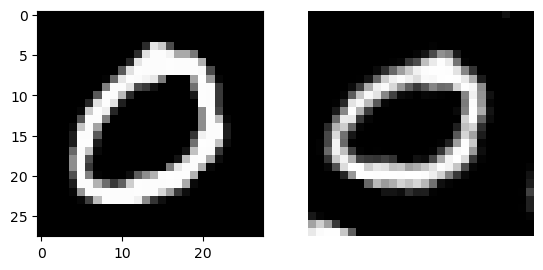

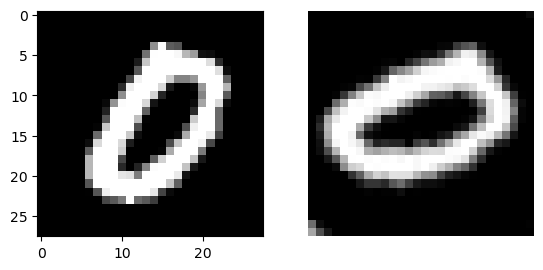

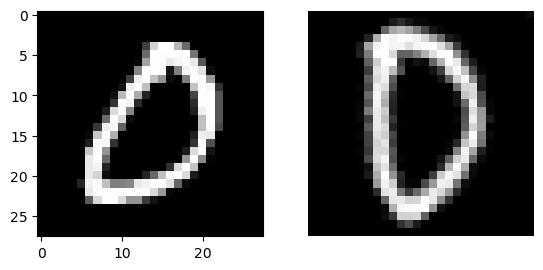

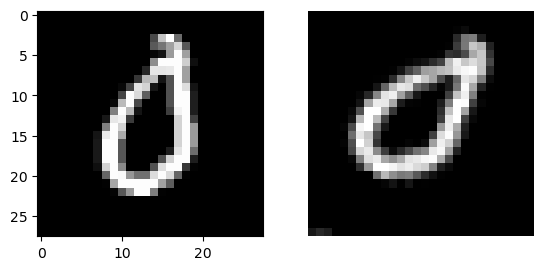

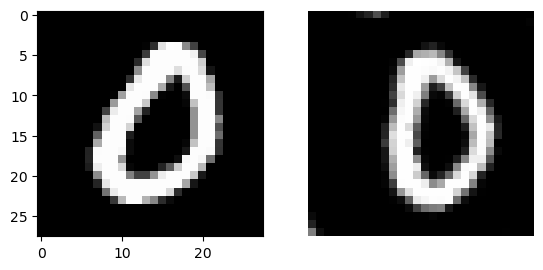

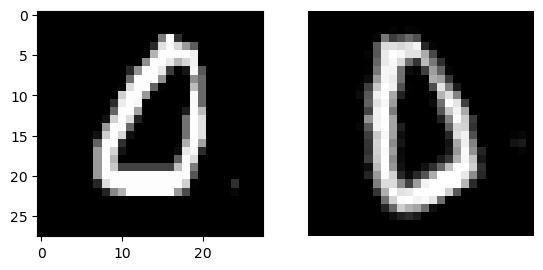

Performing data augmentation for the 12th sample...


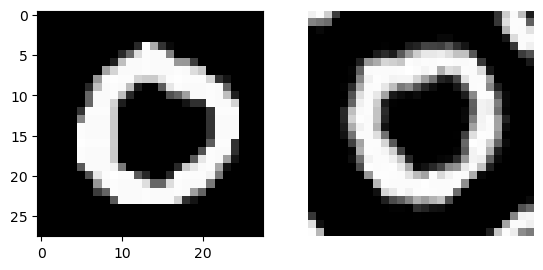

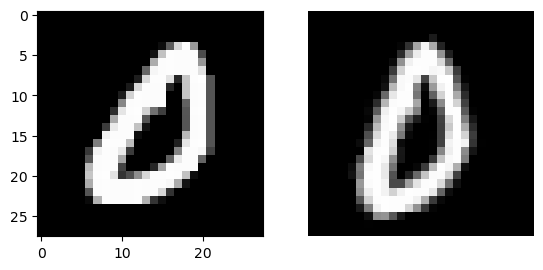

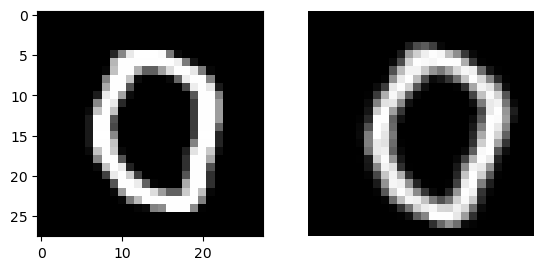

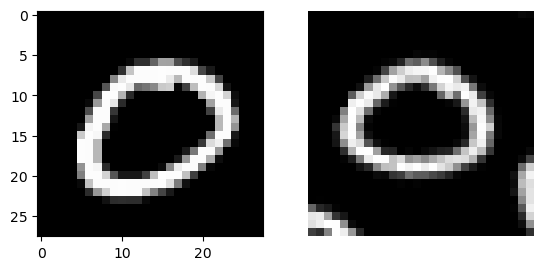

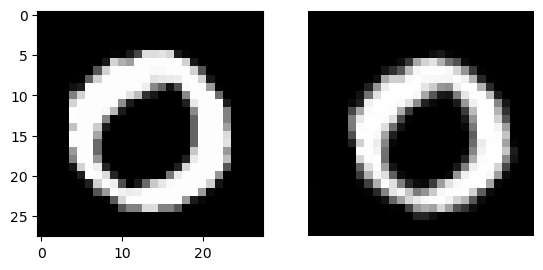

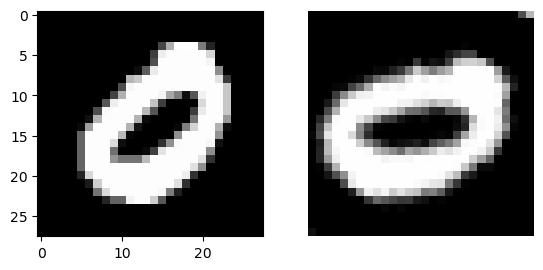

Performing data augmentation for the 13th sample...


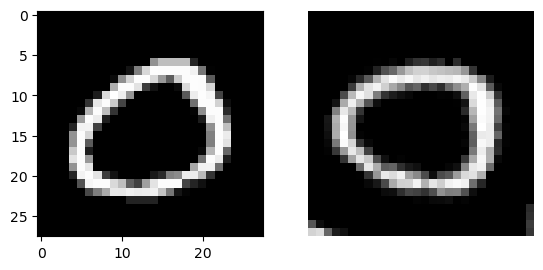

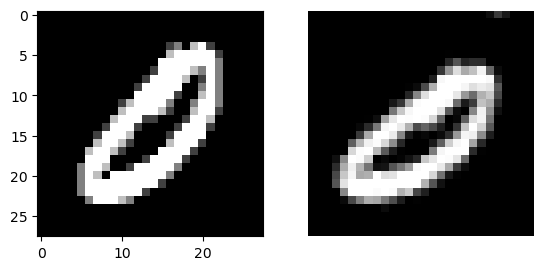

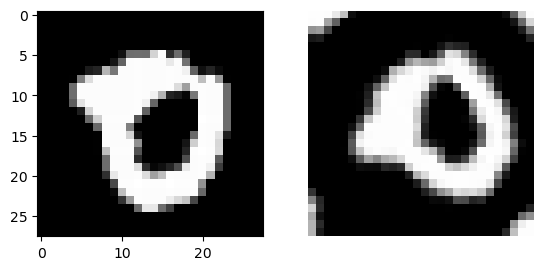

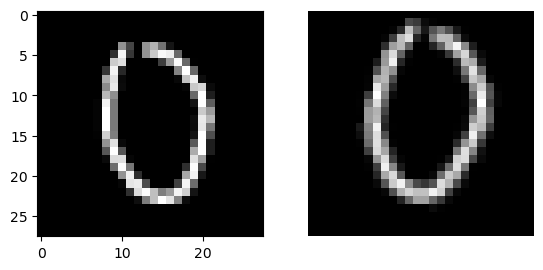

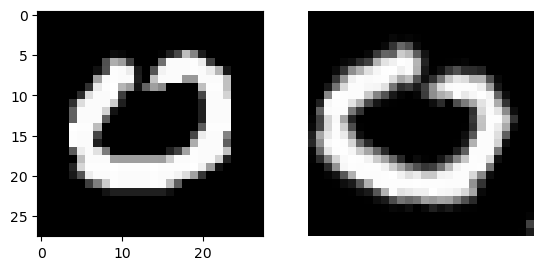

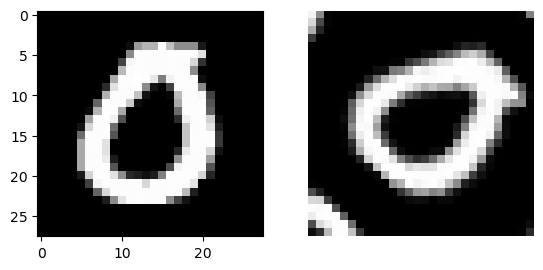

Performing data augmentation for the 14th sample...


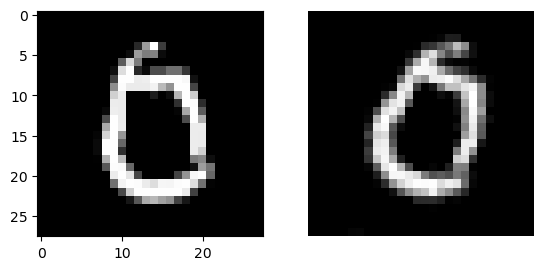

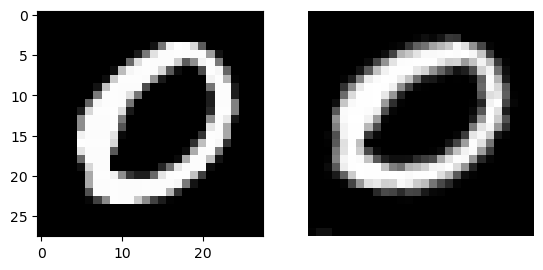

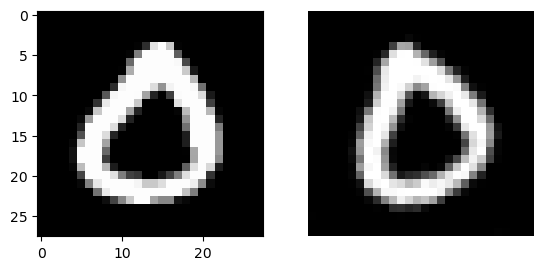

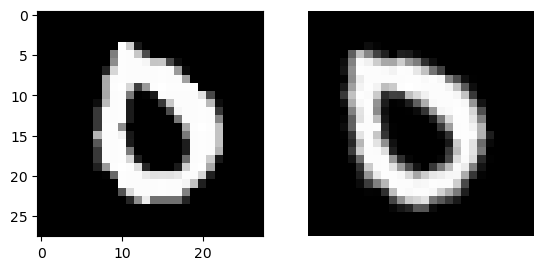

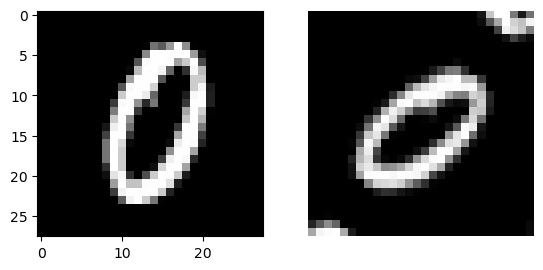

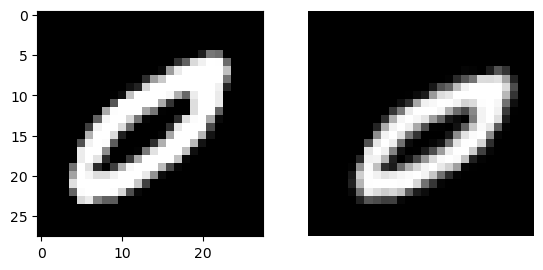

Performing data augmentation for the 15th sample...


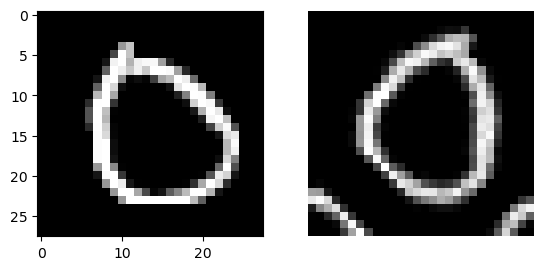

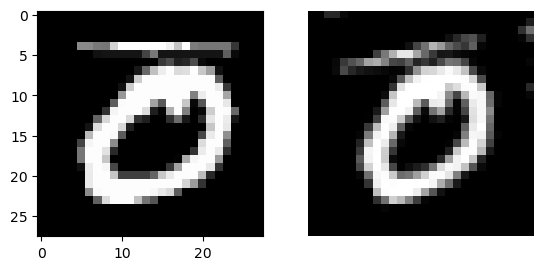

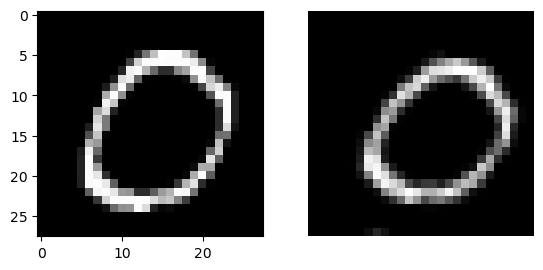

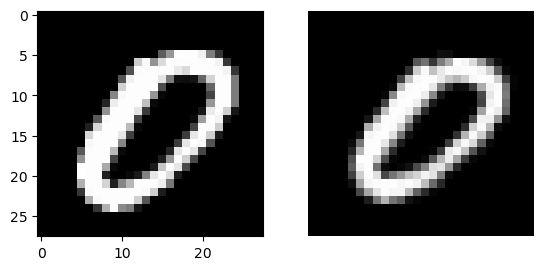

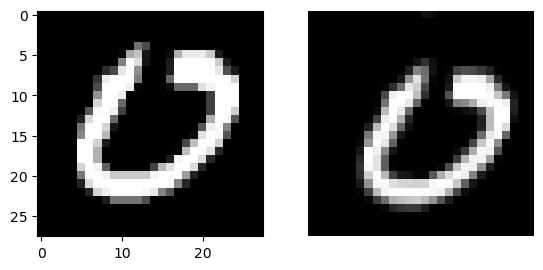

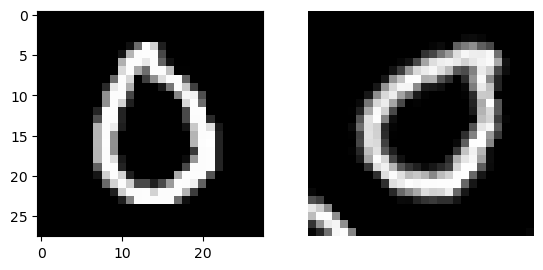

Performing data augmentation for the 16th sample...


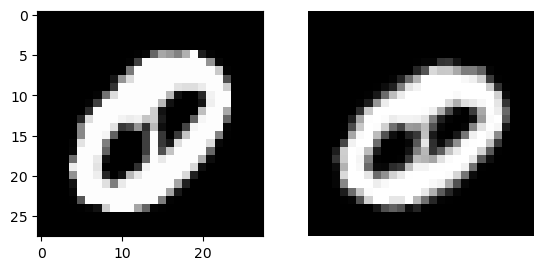

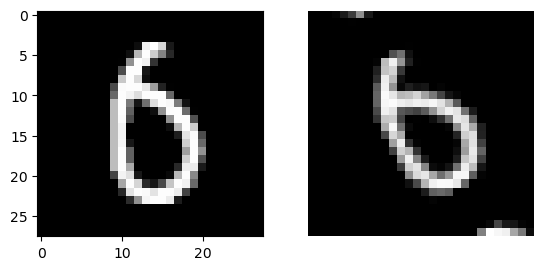

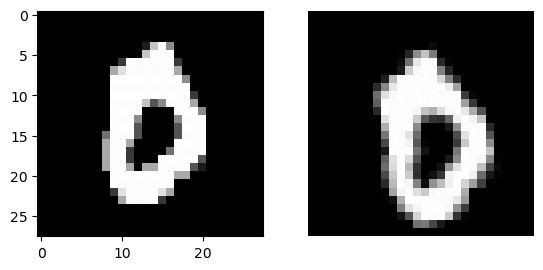

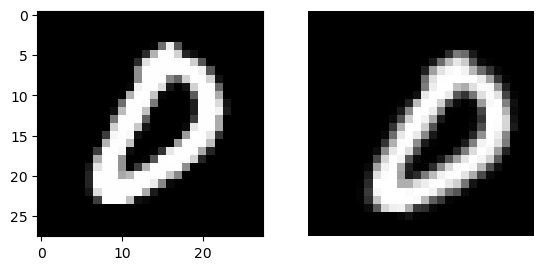

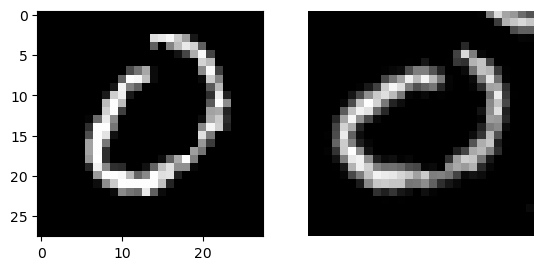

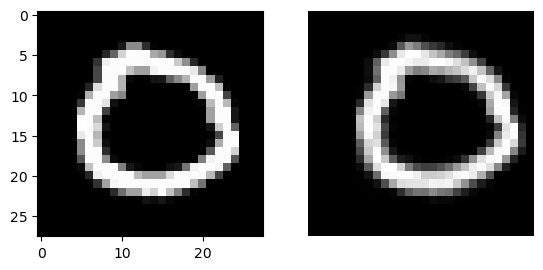

Performing data augmentation for the 17th sample...


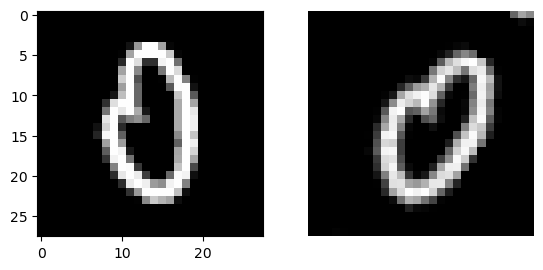

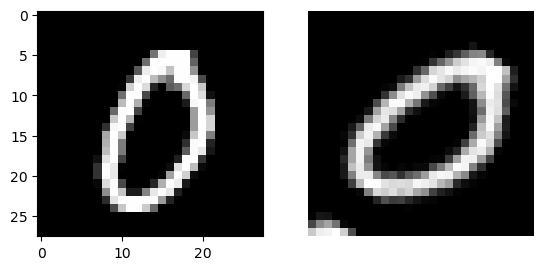

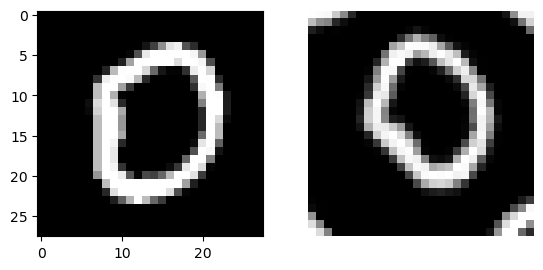

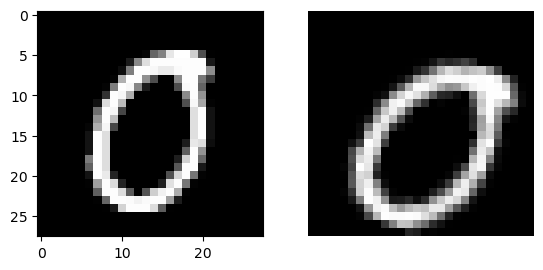

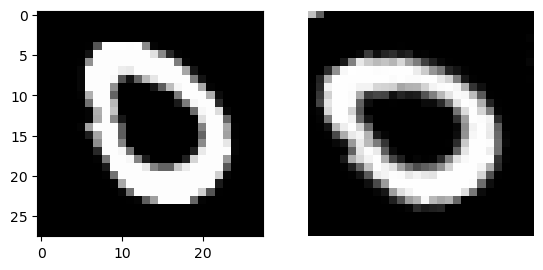

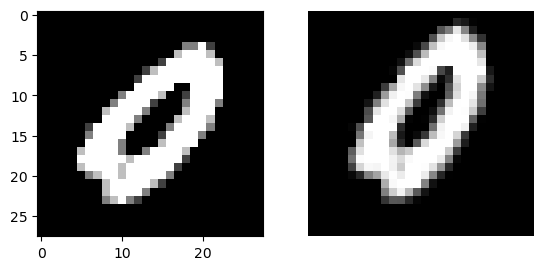

Performing data augmentation for the 18th sample...


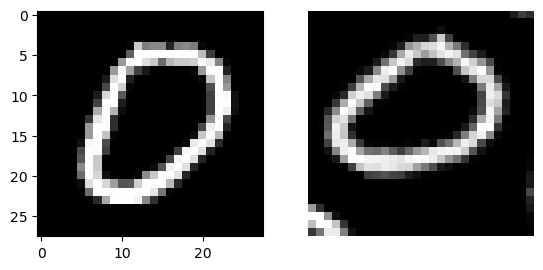

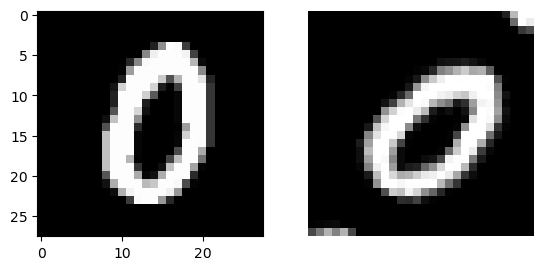

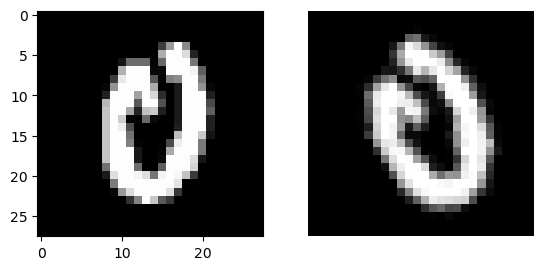

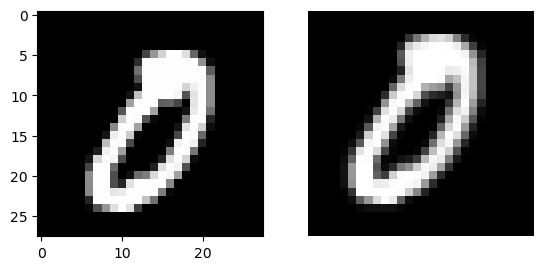

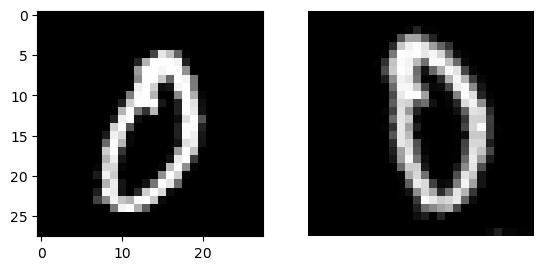

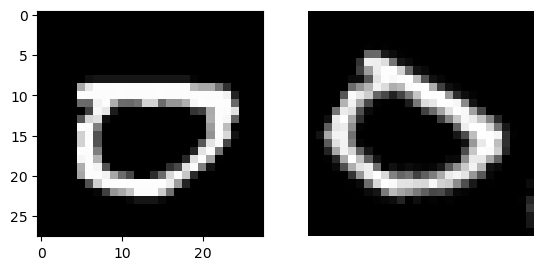

Performing data augmentation for the 19th sample...


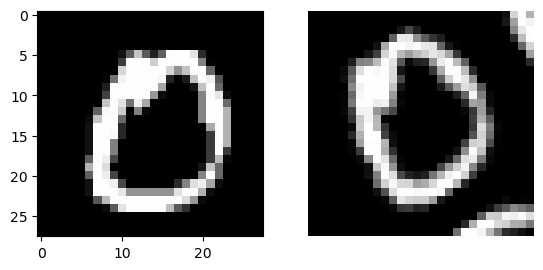

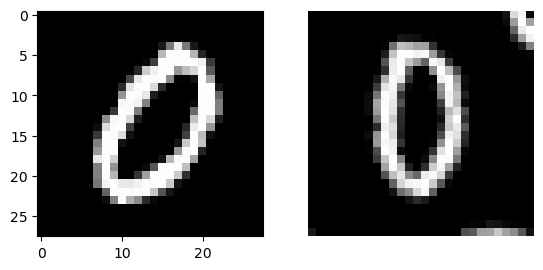

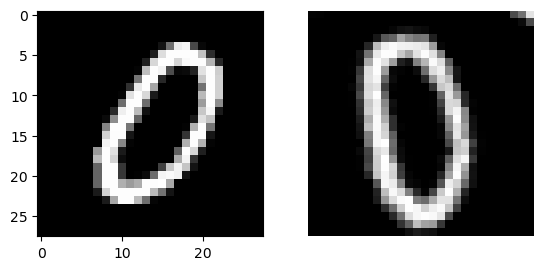

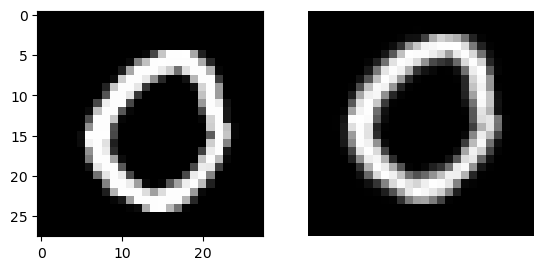

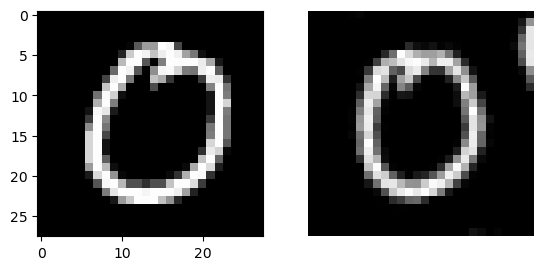

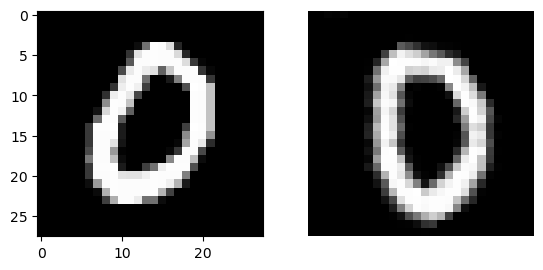

Performing data augmentation for the 20th sample...


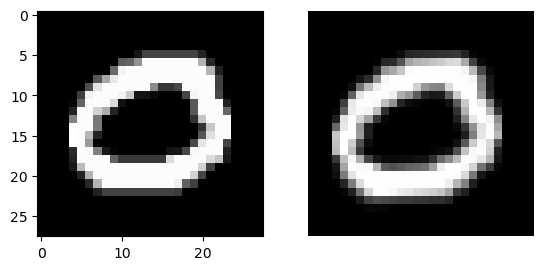

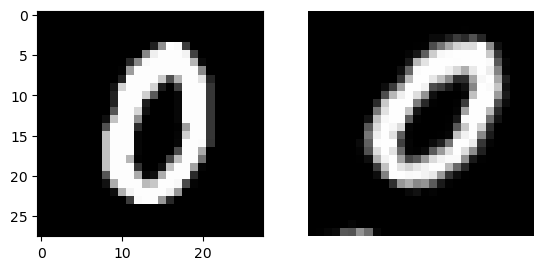

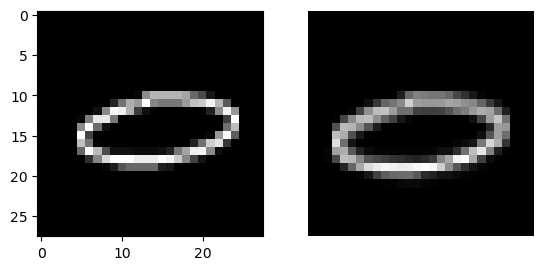

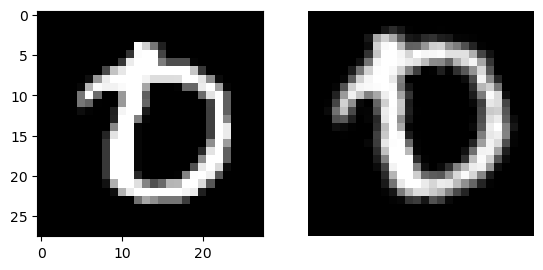

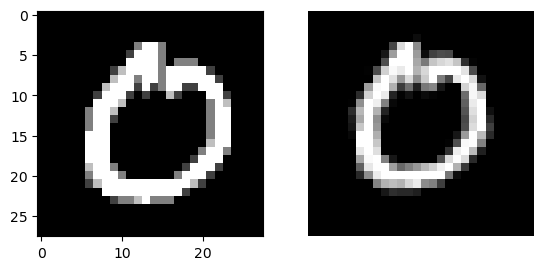

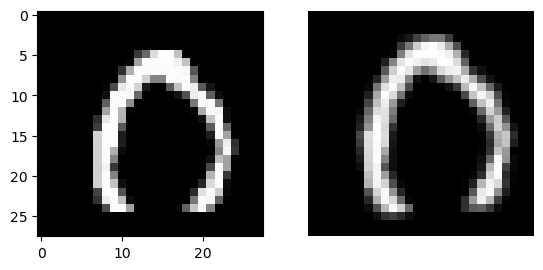

In [28]:
seeds = np.arange(11, 21)
num_samples_per_class_trn = 50
num_samples_per_class_tst = 50
n_augs, n_vis = 1, 5

shift_limit_dx, shift_limit_dy, scale_limit, rotate_limit = 0.0625, 0.0625, 0.1, 45

for i_sample in range(10, 20):
    
    print('Performing data augmentation for the {}th sample...'.format(i_sample+1))
    seed = seeds[i_sample-10]
    
    with open("data/mnist_balanced_sample/sample{}_num_samples_per_class_trn={}_num_samples_per_class_tst={}".format(i_sample+1, num_samples_per_class_trn, num_samples_per_class_tst) + '.pickle', "rb") as fp:
        mydict = pickle.load(fp)
    
    X_ori = mydict['X_ori']
    y_ori = mydict['y_ori']
    X_val = mydict['X_val'].reshape(mydict['X_val'].shape[0], -1)
    y_val = mydict['y_val']
    
    imgs, aug_imgs, y_aug, aug_params = [], [], [], {}
    
    for i, img in enumerate(X_ori):
        img_f = img.flatten()
        imgs.append(img_f)
        aug_img_n = []
        for j in range(n_augs):
            rand_params = get_aug_params(shift_limit_dx, shift_limit_dy, scale_limit, rotate_limit, seed)
            aug_img = shift_scale_rotate(img, rand_params['angle'], rand_params['scale'], rand_params['dx'], rand_params['dy'])
            aug_img_n.append(aug_img)
            aug_params[len(X_ori) + len(aug_imgs)] = rand_params
            aug_imgs.append(aug_img.flatten())
            y_aug.append(y_ori[i])
        if i <= n_vis:
            visualize(img, aug_img_n, n_augs)

    imgs = np.asarray(imgs).astype('int64')
    aug_imgs = np.asarray(aug_imgs).astype('int64')

    X_ori = imgs
    X_aug = aug_imgs
    X_ori_aug = np.concatenate((imgs, aug_imgs))
    y_aug = np.asarray(y_aug)
    y_ori_aug = np.concatenate((y_ori, y_aug))

    mydict = {'X_ori': X_ori, 'y_ori': y_ori, 'X_aug': X_aug, 'y_aug': y_aug, 'X_ori_aug': X_ori_aug,
              'y_ori_aug': y_ori_aug, 'X_val': X_val, 'y_val': y_val, 'aug_params': aug_params}

    with open("data/mnist_balanced_sample/augmented_sample{}_num_samples_per_class_trn={}_num_samples_per_class_tst={}_shift_dx={}_shift_dy={}_scale={}_rotate={}".format(i_sample+1, num_samples_per_class_trn, num_samples_per_class_tst, shift_limit_dx, shift_limit_dy, scale_limit, rotate_limit) + '.pickle', "wb") as fp:
        pickle.dump(mydict, fp)
    